# C. Evaluations Dashboard
This evaluates the following:
- Game projections
- DFS player projections
- DFS lineups 

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"


baseball_path = r'C:\Users\james\Documents\MLB\Database'

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### C01. Scores

In [3]:
%run "C:\Users\james\Documents\MLB\Code\C01. Gambling.ipynb"

##### Read in game results

In [4]:
all_games_df = read_and_save_games(team_map, generate=False)

##### Read in simulation scores

In [21]:
%%time
start_date = "20220407"
end_date = "20220506"

sim_score_df = read_sim_scores(start_date, end_date)

CPU times: total: 1.33 s
Wall time: 4.79 s


In [22]:
date_list = list(sim_score_df['date'].unique())

In [23]:
sim_score_df.query('game_id == 663178').head(1)
sim_score_df2 = sim_score_df.copy()

In [24]:
test = sim_score_df2.query('game_id == 663178')
test['home_score'] = test['home_score'] + 1.5
test['home_cover'] = (test['home_score'] > test['away_score']).astype('int')
test['home_cover'].mean()

0.5

##### Read in Odds

In [25]:
%%time
df = pd.merge(sim_score_df, all_games_df, on='game_id', how='left', suffixes=("", "_act"))

gambling_files = []
for date in date_list:
    odds_df = read_odds(date)
    date_df = pd.merge(df, odds_df, on=['date', 'game_num', 'VisitorTeamShort'], how='inner')
    date_df = gambling_stats_games(date_df)
    date_df['date'] = date
    gambling_files.append(date_df)
    
    
gambling_df = pd.concat(gambling_files, axis=0).reset_index(drop=True)
gambling_df = vegas_runs(gambling_df)
gambling_df.reset_index(inplace=True, drop=True)

CPU times: total: 844 ms
Wall time: 862 ms


In [26]:
# Drop first instance of games that were postponed
gambling_df.drop_duplicates(subset=['game_id'], keep='last', inplace=True)

In [27]:
print("Over/Under\n", gambling_df.query(f'date <= "{end_date}"')['OverUnderPick'].value_counts())

Over/Under
 Under      224
Over       109
Neither     67
Name: OverUnderPick, dtype: int64


In [28]:
# Function to determine SpreadSide
def determine_spread_side(row):
    if (row['SpreadPick'] == 'Away' and row['Spread'] < 0) or (row['SpreadPick'] == 'Home' and row['Spread'] > 0):
        return 'Underdog'
    elif (row['SpreadPick'] == 'Away' and row['Spread'] > 0) or (row['SpreadPick'] == 'Home' and row['Spread'] < 0):
        return 'Favorite'
    else:
        return 'Neither'

# Apply the function to create the SpreadSide column
gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)

print(gambling_df['SpreadSide'].value_counts())

Underdog    236
Favorite    100
Neither      64
Name: SpreadSide, dtype: int64


##### Vegas Runs

In [29]:
gambling_df.query(f'date <= "{end_date}"')[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act', 'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].describe()

,VisitorModelRuns,HomeModelRuns,VisitorVegasRuns,HomeVegasRuns,away_score_act,home_score_act,VisitorModelSqError,HomeModelSqError,VisitorVegasSqError,HomeVegasSqError
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,4.170885,4.190208,4.027500,4.367750,3.967500,4.130000,9.205005,9.387218,8.998000,8.870375
std,0.752101,0.679388,0.701766,0.664258,2.998988,3.052276,14.366428,21.268309,15.052214,18.086865
min,2.270833,2.604167,2.500000,2.900000,0.000000,0.000000,0.000000,0.001736,0.000000,0.000000
25%,3.666667,3.687500,3.500000,3.900000,2.000000,2.000000,1.265625,0.948676,1.000000,1.210000
50%,4.125000,4.166667,4.000000,4.300000,4.000000,3.000000,4.560113,3.633898,4.000000,3.805000
75%,4.609375,4.625000,4.500000,4.800000,6.000000,6.000000,11.320747,10.094184,10.402500,10.240000
max,6.770833,6.250000,7.000000,6.200000,17.000000,21.000000,151.597656,290.418403,156.250000,222.010000


##### Graph Payouts

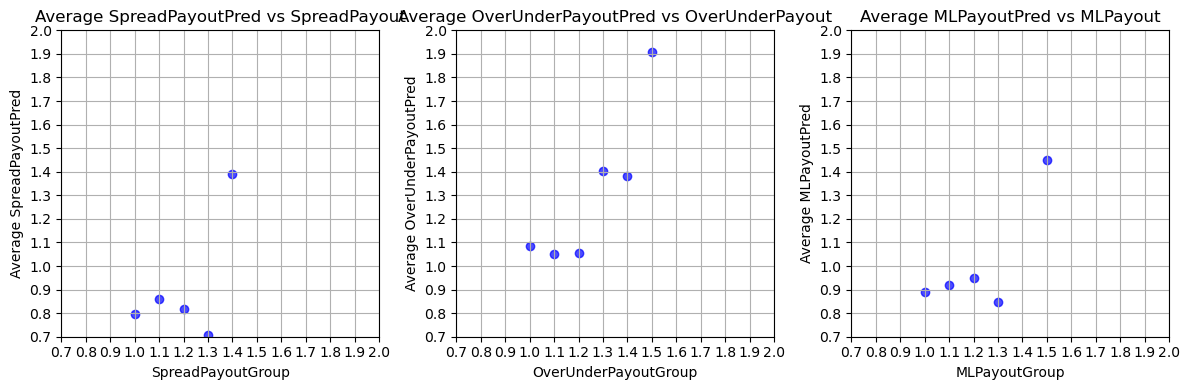

		Spread: 0.8269838816895928				OverUnder: 1.1021651619278892				Money Line: 0.8855427988951905


In [30]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'Spread', ax=axes[0])
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'OverUnder', ax=axes[1])
payout_plotter(gambling_df.query(f"date <= '{end_date}'"), 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = gambling_df.query(f'date <= "{end_date}"')['SpreadPayout'].mean()
OverUnderMean = gambling_df.query(f'date <= "{end_date}"')['OverUnderPayout'].mean()
MLMean = gambling_df.query(f'date <= "{end_date}"')['MLPayout'].mean()
print(f"\t\tSpread: {SpreadMean}\t\t\t\tOverUnder: {OverUnderMean}\t\t\t\tMoney Line: {MLMean}")

In [31]:
significance_test(gambling_df.query(f'(date <= "{end_date}") and ((SpreadPick == "Away" and Spread > 0) or (SpreadPick == "Home" and Spread < 0))'), "Spread", 1, 0.05)
significance_test(gambling_df.query(f'(date <= "{end_date}") and (OverUnderPick == "Under")'), "OverUnder", 1.0, 0.05)
significance_test(gambling_df.query(f'(date <= "{end_date}")'), "ML", 1.26, 0.05)

Average: 1.37306, n: 100, p_value: 0.002, significant: Yes
Average: 1.13174, n: 224, p_value: 0.033, significant: Yes
Average: 0.86119, n: 52, p_value: 0.421, significant: No


In [32]:
gambling_df.query('SpreadPick == "Home" and Spread > 0')['SpreadPayout'].mean()
# gambling_df['SpreadPayout'].mean()

0.608961707241227

In [33]:
gambling_df['ModelDiff'] = (gambling_df['VisitorModelRuns'] - gambling_df['HomeModelRuns']).abs()
gambling_df['VegasDiff'] = (gambling_df['VisitorVegasRuns'] - gambling_df['HomeVegasRuns']).abs()
gambling_df.describe()

,game_id,game_num,VisitorModelRuns,HomeModelRuns,away_id,home_id,game_num_act,away_score_act,home_score_act,venue_id,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,AwaySpreadPred,HomeSpreadPred,UnderPred,OverPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,UnderAct,OverAct,AwayMLAct,HomeMLAct,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,ModelDiff,VegasDiff
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,338.000000,333.000000,334.000000,338.000000,332.000000,333.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,662275.952500,1.017500,4.170885,4.190208,128.362500,129.110000,1.030000,3.967500,4.130000,1527.295000,-0.235000,8.203750,1.918350,2.032564,1.914205,1.914205,2.149654,1.855258,4.027500,4.367750,8.361094,0.447500,0.514792,0.037708,8.097500,0.425000,0.540000,0.035000,0.522344,0.476146,0.001510,0.525000,0.475000,0.000000,0.474583,0.525417,0.480000,0.520000,0.971647,0.936296,1.022949,0.894665,0.995702,0.955192,0.946782,1.082015,1.069625,0.847754,0.978370,0.923222,0.826984,1.102165,0.885543,1.116012,1.144726,1.149845,0.203385,0.060000,9.205005,8.998000,0.060208,0.237750,9.387218,8.870375,8.395250,0.743490,0.823750
std,684.669867,0.131289,0.752101,0.679388,14.330020,14.333930,0.170801,2.998988,3.052276,1714.700779,1.473585,0.985031,0.329562,0.349754,0.050278,0.050278,0.442702,0.344775,0.701766,0.664258,1.087862,0.102963,0.100949,0.055734,4.234717,0.494962,0.499022,0.184010,0.131277,0.130691,0.015146,0.500000,0.500000,0.000000,0.100865,0.100865,0.500226,0.500226,0.171901,0.180457,0.188079,0.190454,0.199281,0.168225,1.015104,1.069404,0.936363,0.934788,1.058905,0.916970,1.013462,0.930194,1.078141,0.098246,0.115305,0.126964,3.030941,3.002822,14.366428,15.052214,3.067101,2.972531,21.268309,18.086865,1.011663,0.563218,0.528924
min,661032.000000,1.000000,2.270833,2.604167,108.000000,108.000000,1.000000,0.000000,0.000000,1.000000,-1.500000,6.500000,1.476190,1.471698,1.800000,1.800000,1.400000,1.266667,2.500000,2.900000,5.854167,0.208333,0.166667,0.000000,1.000000,0.000000,0.000000,0.000000,0.145833,0.145833,0.000000,0.000000,0.000000,0.000000,0.229167,0.229167,0.000000,0.000000,0.427083,0.319375,0.326923,0.397727,0.517045,0.486111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001645,1.000000,1.000000,-12.312500,-12.500000,0.000000,0.000000,-17.041667,-14.900000,0.001736,0.000000,6.600000,0.000000,0.000000
25%,661733.750000,1.000000,3.666667,3.687500,114.000000,115.000000,1.000000,2.000000,2.000000,12.000000,-1.500000,7.500000,1.640005,1.729927,1.877193,1.877193,1.787402,1.594358,3.500000,3.900000,7.541667,0.375000,0.458333,0.000000,5.000000,0.000000,0.000000,0.000000,0.416667,0.375000,0.000000,0.000000,0.000000,0.000000,0.395833,0.458333,0.000000,0.000000,0.858670,0.825000,0.906994,0.765871,0.846977,0.834371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.041094,1.051970,1.061869,-1.458333,-1.600000,1.265625,1.000000,-1.437500,-1

In [34]:
# You're almost impossibly bad at spreads lol
# Might be good to know why
# Very good when predicting unders (Biased toward over)
# I think you're probably always taking the points in the Spreads
# Theory: You're always predicting close games. Because of this, your spread pick is always the points. 


##### Graph Runs

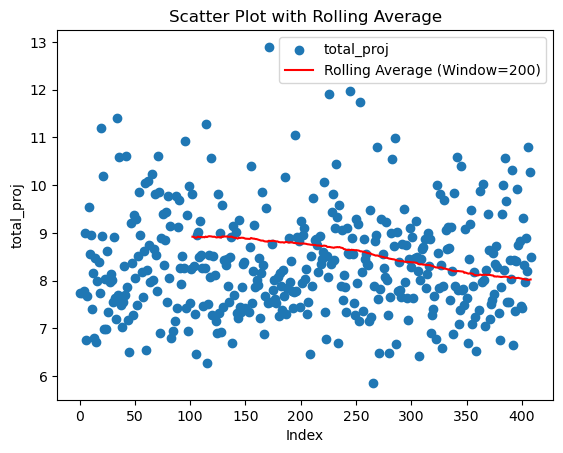

In [35]:
# Total: Choose Vegas or Actual to compare my runs to 
total = "TotalVegasRuns"

# You can convert the index to a list for the x-axis and get the values for the y-axis
x_values = gambling_df.index.tolist()
y_values = gambling_df['total_proj'].tolist()

# Calculate the rolling average
rolling_avg = gambling_df[f'{total}'].rolling(window=200, min_periods=100).mean()

# Create a scatter plot
plt.scatter(x_values, y_values, label='total_proj')

# Add the rolling average line
plt.plot(x_values, rolling_avg, color='red', label='Rolling Average (Window=200)')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('total_proj')
plt.title('Scatter Plot with Rolling Average')
plt.legend()

# Show the plot
plt.show()

In [20]:
afadsfaf

NameError: name 'afadsfaf' is not defined

### C02. Projections

In [ ]:
%run "C:\Users\james\Documents\MLB\Code\C02. Projections.ipynb"

In [ ]:
# Read in contest history
history = pd.read_csv(os.path.join(baseball_path, "Utilities", "draftkings-contest-entry-history.csv"))

In [ ]:
# Read in cleaned contest history (this needs to be fixed long-term)
contests = pd.read_csv(os.path.join(baseball_path, "Utilities", "Contests.csv"))
contests = contests[::-1]

In [ ]:
contests = contests[~contests['draftGroupId'].isna()].reset_index(drop=True)

In [ ]:
comparable_dfs = []
for i in range(len(contests)):
    try:
        contestKey = contests['contestKey'][i].astype('int')
        draftGroupId = contests['draftGroupId'][i].astype('int')

        # print(draftGroupId)

        # Read in projection dataframes
        my_df = read_player_sims(draftGroupId)
        # print(my_df.head(10))
        dff_df = read_dff(contestKey, history)
        roto_df = read_roto(contestKey, history)

        # Merge them together
        projection_df = merge_projections(my_df, dff_df, roto_df, quietly=True)

        # Read in contest results
        score_df = read_results(contestKey)

        # Evaluate projections
        complete_df = evaluate_projections_post(projection_df, score_df)
        comparable_df = compare_projections(complete_df)
        
        # print("Me: ", len(my_df['TeamAbbrev'].unique()), "DFF: ", len(dff_df['TeamAbbrev'].unique()), "Roto: ", len(roto_df['TeamAbbrev'].unique()), "Merged:", len(comparable_df['TeamAbbrev'].unique()))
        # print("Me: ", len(my_df), "DFF: ", len(dff_df), "Roto:", len(roto_df), "Merged:", len(comparable_df))
        
        # Add to list of dataframes
        comparable_dfs.append(comparable_df)
        
    except:
        pass

In [ ]:
all_projections = pd.concat(comparable_dfs, axis=0).head(360000)
len(all_projections)

In [ ]:
batter_means = all_projections.query('`Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means = all_projections.query('`Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means = all_projections.query('Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')


batter_means_unimp = all_projections.query('imp == 0 and `Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means_unimp = all_projections.query('imp == 0 and `Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means_unimp = all_projections.query('imp == 0 and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')

batter_means_imp = all_projections.query('imp == 1 and `Roster Position` != "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
pitcher_means_imp = all_projections.query('imp == 1 and `Roster Position` == "P" and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')
all_means_imp = all_projections.query('imp == 1 and Projection_Me > 0 and Projection_DFF > 0 and Projection_Roto > 0').agg('mean')



means_df = pd.concat([batter_means, pitcher_means, all_means, batter_means_unimp, pitcher_means_unimp, all_means_unimp, batter_means_imp, pitcher_means_imp, all_means_imp], axis=1).T
means_df.set_index(pd.Index(["Batters", "Pitchers", "All", "Batters Unimp", "Pitchers Unimp", "All Unimp", "Batters Imp", "Pitchers Imp", "All Imp"]), inplace=True)

means_df.drop(columns={'ownership'})